In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pqcd

from pathlib import Path
from pqcd.utils import (
    to_GeV_per_cubic_femtometre, 
    to_nucleons_per_cubic_femtometre, 
    nsat
)

In [2]:
set_number = 11
varieties = ['had', 'hyp', 'qrk']

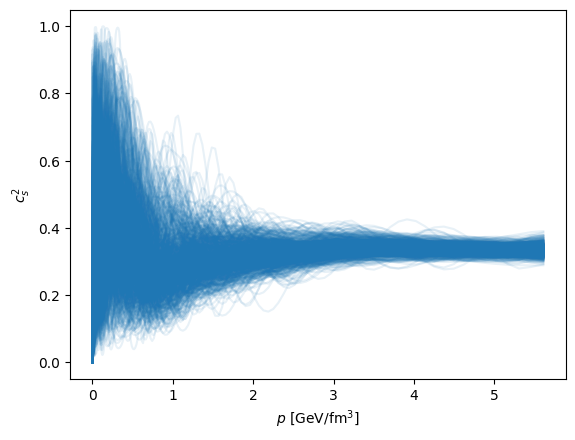

In [3]:
fig, ax = plt.subplots()

for variety in varieties:

    working_dir = Path(f'../data/eos-draws-modified/{set_number:02}/{variety}agn')

    for eos_dir in [f for f in working_dir.iterdir() if f.is_dir()]:

        for eos_path in [f for f in eos_dir.iterdir()]:

            if eos_path.name[:3] == 'eos':

                eos = pd.read_csv(eos_path)

                pressure = to_GeV_per_cubic_femtometre(eos.pressurec2)
                energy_density = to_GeV_per_cubic_femtometre(eos.energy_densityc2)
                number_density = to_nucleons_per_cubic_femtometre(eos.baryon_density)

                chemical_potential = (energy_density+pressure)/number_density
                speed_of_sound_squared = np.gradient(pressure, energy_density)

                ax.plot(
                    pressure,
                    speed_of_sound_squared, 
                    alpha=0.1, 
                    c='C0'
                    )
            
ax.set_xlabel(r'$p$ [GeV/fm$^3$]')
_ = ax.set_ylabel(r'$c_s^2$')

In [4]:
# Some example (mu [GeV], n [1/fm^3], p [GeV/fm^3]) values for chiEFT
CET_values = {
    'soft': [0.966, 0.176, 2.163/1000],
    'stiff': [0.978, 0.176, 3.542/1000]
}

muL, nL, pL = CET_values['soft']
epsilonL = pqcd.epsilon_func(muL, nL, pL)

X = 1
muH = 2.6
pQCDX = pqcd.pQCD(X)
nH, pH = pQCDX.nH(muH), pQCDX.pH(muH)
epsilonH = pqcd.epsilon_func(muH, nH, pH)

mu_array = np.linspace(muL, muH, 1000)

849


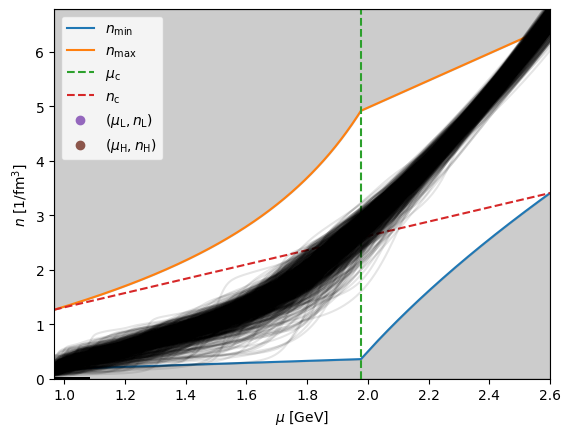

In [22]:
constraints = pqcd.constraints(muL, nL, pL, muH, nH, pH)
fig, ax = constraints.plot_mu_n(mu_array)

count = 0

for variety in varieties:

    working_dir = Path(f'../data/eos-draws-modified/{set_number:02}/{variety}agn')

    for eos_dir in [f for f in working_dir.iterdir() if f.is_dir()]:

        for eos_path in [f for f in eos_dir.iterdir()]:

            if eos_path.name[:3] == 'eos':

                count += 1

                eos = pd.read_csv(eos_path)

                pressure = to_GeV_per_cubic_femtometre(eos.pressurec2)
                energy_density = to_GeV_per_cubic_femtometre(eos.energy_densityc2)
                number_density = to_nucleons_per_cubic_femtometre(eos.baryon_density)

                chemical_potential = (energy_density+pressure)/number_density
                speed_of_sound_squared = np.gradient(pressure, energy_density)

                ax.plot(
                    chemical_potential,
                    number_density, 
                    alpha=0.1, 
                    c='k'
                    )
                
print(count)

In [19]:
100*(849/150000)

0.5660000000000001

In [21]:
100*(495/50000)

0.9900000000000001

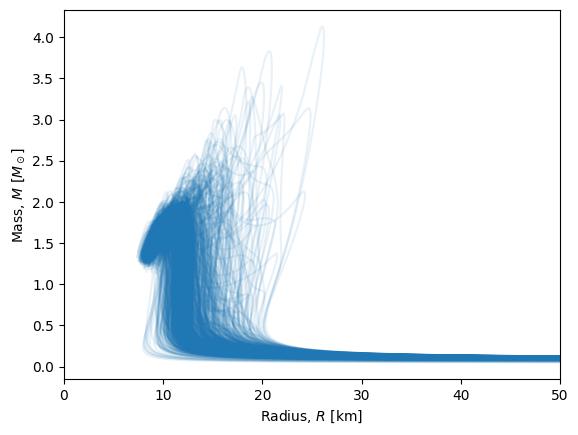

In [7]:
fig, ax = plt.subplots()

for variety in varieties:

    working_dir = Path(f'../data/eos-draws-modified/{set_number:02}/{variety}agn')

    for eos_dir in [f for f in working_dir.iterdir() if f.is_dir()]:

        for eos_path in [f for f in eos_dir.iterdir()]:

            if eos_path.name[:5] == 'macro':

                df = pd.read_csv(eos_path)

                mass = df.M
                radius = df.R

                ax.plot(
                    radius,
                    mass,
                    alpha=0.1, 
                    c='C0',
                    )

ax.set_xlim(0, 50)

ax.set_xlabel('Radius, $R$ [km]')
_ = ax.set_ylabel('Mass, $M$ [$M_\odot$]')

In [8]:
Mmax_list = []
R14_list = []

for variety in varieties:

    working_dir = Path(f'../data/eos-draws-modified/{set_number:02}/{variety}agn')

    for eos_dir in [f for f in working_dir.iterdir() if f.is_dir()]:

        for eos_path in [f for f in eos_dir.iterdir()]:

            if eos_path.name[:5] == 'macro':

                df = pd.read_csv(eos_path)

                mass = df.M
                radius = df.R

                # Get the mass-radius curve below 50km
                eos_mask = radius < 50
                mass = mass[eos_mask]
                radius = radius[eos_mask]

                if len(mass) == 0:
                    Mmax_list.append(np.nan)
                    R14_list.append(np.nan)
                    continue

                Mmax_index = np.argmax(mass)
                Mmax = mass.iloc[Mmax_index]

                Mmax_list.append(Mmax)

                R14_index = np.argmin(np.abs(radius - 1.4))
                R14 = radius.iloc[R14_index]

                R14_list.append(R14)

In [25]:
Mmax_list = np.array(Mmax_list)
R14_list = np.array(R14_list)

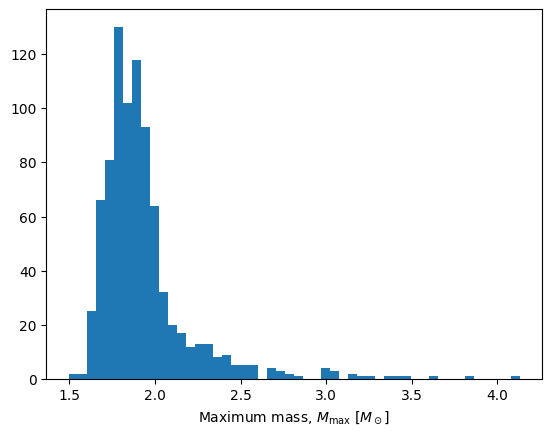

In [10]:
fig, ax = plt.subplots()

ax.hist(
    Mmax_list, 
    bins=50, 
    alpha=1, 
)

_ = ax.set_xlabel('Maximum mass, $M_{\mathrm{max}}$ [$M_\odot$]')

In [23]:
len(Mmax_list)

849

In [26]:
len(Mmax_list[Mmax_list > 2])

186

An old method of checking whether the EOSs come close to the pQCD prediction:

In [ ]:
# Some reference pQCD values
X = 2
muH = 2.6

pQCDX = pqcd.pQCD(X)

epsilonH = pQCDX.epsilonH(muH)
pH = pQCDX.pH(muH)
nH = pQCDX.nH(muH)

In [ ]:
number_density_array = np.linspace(0.9*nH, 1.1*nH, 100)

near_EOSs = {}

fig, axs = plt.subplots(1, 2, figsize=(10,4))

axs[0].plot(pH, epsilonH, 'C3', marker='o', markersize=12, zorder=5)
axs[1].plot(muH, nH/nsat, 'C3', marker='o', markersize=12, zorder=5)

xlim0 = axs[0].get_xlim()
ylim0 = axs[0].get_ylim()

xlim1 = axs[1].get_xlim()
ylim1 = axs[1].get_ylim()

min_mu = muH

N_samp = 1000

for variety in ['had', 'hyp', 'qrk']:

    near_EOSs[variety] = []

    for n in range(N_samp):

        df = pd.read_csv(f'../data/eos-draws-modified/00/{variety}agn/eos-draw-{n:06}.csv')

        pressure = to_GeV_per_cubic_femtometre(df.pressurec2).values
        energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2).values
        number_density = to_nucleons_per_cubic_femtometre(df.baryon_density).values
        chemical_potential = (energy_density+pressure)/number_density

        if min(chemical_potential) < min_mu:
            min_mu = min(chemical_potential)

        # Build an interpolant over number density
        pressure_interp = interp1d(number_density, pressure, bounds_error=False)
        energy_density_interp = interp1d(number_density, energy_density, bounds_error=False)
        chemical_potential_interp = interp1d(number_density, chemical_potential, bounds_error=False)

        # Check we reach the pQCD pressure
        if not np.isnan(pressure_interp(nH)):

            pressure_dense = pressure_interp(number_density_array)
            energy_density_dense = energy_density_interp(number_density_array)
            chemical_potential_dense = chemical_potential_interp(number_density_array)

            # Get the part of the EOS array within 10% of the pQCD pressure
            near_eos = np.where((pressure_dense > 0.9*pH) & (pressure_dense < 1.1*pH))[0]

            # Get the EOSs that are also within 10% of the pQCD energy density
            # near_eos = near_eos[
            #     np.where(
            #         (energy_density_dense[near_eos] > 0.9*epsilonH) & 
            #         (energy_density_dense[near_eos] < 1.1*epsilonH)
            #     )[0]
            # ]

            # Get the EOSs that are also within 10% of the pQCD chemical potential
            near_eos = near_eos[
                np.where(
                    (chemical_potential_dense[near_eos] > 0.9*muH) & 
                    (chemical_potential_dense[near_eos] < 1.1*muH)
                )[0]
            ]

            if len(near_eos) > 0:
                near_EOSs[variety].append(n)

            axs[0].plot(
                pressure,
                energy_density, 
                alpha=0.05, 
                c='C0' if len(near_eos) == 0 else 'C1',
                zorder = 0 if len(near_eos) == 0 else 1
                )
            
            axs[1].plot(
                chemical_potential,
                number_density/nsat, 
                alpha=0.05, 
                c='C0' if len(near_eos) == 0 else 'C1',
                zorder = 0 if len(near_eos) == 0 else 1
                )

axs[0].set_xlim(min_pressure, xlim0[1])
axs[0].set_ylim(0, ylim0[1])

axs[1].set_xlim(min_mu, xlim1[1])
axs[1].set_ylim(0, ylim1[1])

axs[0].set_xlabel(r'Pressure, $P$ [GeV/fm$^3$]')
axs[0].set_ylabel(r'Energy density, $\epsilon$ [GeV/fm$^3]$')

axs[1].set_xlabel(r'Chemical potential, $\mu$ [GeV]')
_ = axs[1].set_ylabel(r'Number density, $n$ $[n_{\rm sat}]$')

In [ ]:
for l in near_EOSs.values():
    print(len(l))

In [ ]:
fig, ax = plt.subplots()
# ax.set_yscale('log')

number_density_array = np.linspace(0.9*nH, 1.1*nH, 100)

N_samp = 1000

c_dict = {'had': 'C0', 'hyp': 'C1', 'qrk': 'C2'}

for variety in ['had', 'hyp', 'qrk']:

    for n in range(N_samp):

        df = pd.read_csv(f'../data/eos-draws-modified/00/{variety}agn/eos-draw-{n:06}.csv')

        pressure = to_GeV_per_cubic_femtometre(df.pressurec2).values
        energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2).values
        number_density = to_nucleons_per_cubic_femtometre(df.baryon_density).values
        chemical_potential = (energy_density+pressure)/number_density

        # Build an interpolant over number density
        pressure_interp = interp1d(number_density, pressure, bounds_error=False)
        energy_density_interp = interp1d(number_density, energy_density, bounds_error=False)
        chemical_potential_interp = interp1d(number_density, chemical_potential, bounds_error=False)

        # Check we reach the pQCD pressure
        if not np.isnan(pressure_interp(nH)):

            # Get the pressure and chemical potential at nH
            pressure_nH = pressure_interp(nH)
            chemical_potential_nH = chemical_potential_interp(nH)

            ax.plot(
                chemical_potential_nH,
                pressure_nH, 
                alpha=0.25, 
                c='C0' if n not in near_EOSs[variety] else 'C1',
                marker='o',
                markeredgewidth=0,
                )   
            
ax.axhline(pH, c='C1', ls='--')
ax.axvline(muH, c='C1', ls='--')

# ax.axhline(0.9*pH, c='k', ls='--', alpha=0.25)
# ax.axvline(0.9*muH, c='k', ls='--', alpha=0.25)

from matplotlib.patches import Rectangle
ax.add_artist(
    Rectangle(
        (0.9*muH, 0.9*pH), 
        0.2*muH, 0.2*pH, 
        linewidth=2, 
        edgecolor='k', 
        facecolor='none'
    )
)

ax.set_xlabel(r'Chemical potential at $n_\mathrm{H}$, $\mu$ [GeV]')
_ = ax.set_ylabel(r'Pressure at $n_\mathrm{H}$, $P$ [GeV/fm$^3]$')

In [ ]:
collated_eos = pd.read_csv('../data/collated_np_all_post.csv')

number_density_array = np.linspace(0.9*nH, 1.1*nH, 100)

near_EOSs_default = []

fig, axs = plt.subplots(1, 2, figsize=(10,4))

axs[0].plot(pH, epsilonH, 'C3', marker='o', markersize=12, zorder=5)
axs[1].plot(muH, nH/nsat, 'C3', marker='o', markersize=12, zorder=5)

xlim0 = axs[0].get_xlim()
ylim0 = axs[0].get_ylim()

xlim1 = axs[1].get_xlim()
ylim1 = axs[1].get_ylim()

min_mu = muH

N_samp = 1000
for eos in collated_eos.eos[:N_samp]:

    df = pd.read_csv(f'../data/eos-draws-default/eos-draw-{int(eos):06}.csv')

    pressure = to_GeV_per_cubic_femtometre(df.pressurec2).values
    energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2).values
    number_density = to_nucleons_per_cubic_femtometre(df.baryon_density).values
    chemical_potential = (energy_density+pressure)/number_density

    if min(chemical_potential) < min_mu:
        min_mu = min(chemical_potential)

    # Build an interpolant over number density
    pressure_interp = interp1d(number_density, pressure, bounds_error=False)
    energy_density_interp = interp1d(number_density, energy_density, bounds_error=False)
    chemical_potential_interp = interp1d(number_density, chemical_potential, bounds_error=False)

    # Check we reach the pQCD pressure
    if not np.isnan(pressure_interp(nH)):

        pressure_dense = pressure_interp(number_density_array)
        energy_density_dense = energy_density_interp(number_density_array)
        chemical_potential_dense = chemical_potential_interp(number_density_array)

        # Get the part of the EOS array within 10% of the pQCD pressure
        near_eos = np.where((pressure_dense > 0.9*pH) & (pressure_dense < 1.1*pH))[0]

        # Get the EOSs that are also within 10% of the pQCD energy density
        # near_eos = near_eos[
        #     np.where(
        #         (energy_density_dense[near_eos] > 0.9*epsilonH) & 
        #         (energy_density_dense[near_eos] < 1.1*epsilonH)
        #     )[0]
        # ]

        # Get the EOSs that are also within 10% of the pQCD chemical potential
        near_eos = near_eos[
            np.where(
                (chemical_potential_dense[near_eos] > 0.9*muH) & 
                (chemical_potential_dense[near_eos] < 1.1*muH)
            )[0]
        ]

        if len(near_eos) > 0:
            near_EOSs_default.append(eos)

        axs[0].plot(
            pressure,
            energy_density, 
            alpha=0.5, 
            c='C0' if len(near_eos) == 0 else 'C1',
            zorder = 0 if len(near_eos) == 0 else 1
            )
        
        axs[1].plot(
            chemical_potential,
            number_density/nsat, 
            alpha=0.5, 
            c='C0' if len(near_eos) == 0 else 'C1',
            zorder = 0 if len(near_eos) == 0 else 1
            )

axs[0].set_xlim(min_pressure, xlim0[1])
axs[0].set_ylim(0, ylim0[1])

axs[1].set_xlim(min_mu, xlim1[1])
axs[1].set_ylim(0, ylim1[1])

axs[0].set_xlabel(r'Pressure, $P$ [GeV/fm$^3$]')
axs[0].set_ylabel(r'Energy density, $\epsilon$ [GeV/fm$^3$')

axs[1].set_xlabel(r'Chemical potential, $\mu$ [GeV]')
_ = axs[1].set_ylabel(r'Number density, $n$ $[n_{\rm sat}]$')

In [ ]:
len(near_EOSs_default)

In [ ]:
collated_eos = pd.read_csv('../data/eos-draws-default.csv')

fig, ax = plt.subplots()
# ax.set_yscale('log')

number_density_array = np.linspace(0.9*nH, 1.1*nH, 100)

c_dict = {'had': 'C0', 'hyp': 'C1', 'qrk': 'C2'}

N_samp = 2000
for eos in collated_eos.eos[:N_samp]:

    df = pd.read_csv(f'../data/eos-draws-default/eos-draw-{int(eos):06}.csv')

    pressure = to_GeV_per_cubic_femtometre(df.pressurec2).values
    energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2).values
    number_density = to_nucleons_per_cubic_femtometre(df.baryon_density).values
    chemical_potential = (energy_density+pressure)/number_density

    # Build an interpolant over number density
    pressure_interp = interp1d(number_density, pressure, bounds_error=False)
    energy_density_interp = interp1d(number_density, energy_density, bounds_error=False)
    chemical_potential_interp = interp1d(number_density, chemical_potential, bounds_error=False)

    # Check we reach the pQCD pressure
    if not np.isnan(pressure_interp(nH)):

        # Get the pressure and chemical potential at nH
        pressure_nH = pressure_interp(nH)
        chemical_potential_nH = chemical_potential_interp(nH)

        ax.plot(
            chemical_potential_nH,
            pressure_nH, 
            alpha=0.25, 
            c='C0' if eos not in near_EOSs_default else 'C1',
            marker='o',
            markeredgewidth=0,
            )   
            
ax.axhline(pH, c='C1', ls='--')
ax.axvline(muH, c='C1', ls='--')

# ax.axhline(0.9*pH, c='k', ls='--', alpha=0.25)
# ax.axvline(0.9*muH, c='k', ls='--', alpha=0.25)

from matplotlib.patches import Rectangle
ax.add_artist(
    Rectangle(
        (0.9*muH, 0.9*pH), 
        0.2*muH, 0.2*pH, 
        linewidth=2, 
        edgecolor='k', 
        facecolor='none'
    )
)

ax.set_xlim((0.8185820921299894, 3.5448374752987086))
ax.set_ylim((-0.28018001533245745, 5.889989222819642))

ax.set_xlabel(r'Chemical potential at $n_\mathrm{H}$, $\mu$ [GeV]')
_ = ax.set_ylabel(r'Pressure at $n_\mathrm{H}$, $P$ [GeV/fm$^3]$')